#Master equation model of the alanine octapeptide

First we import a number of libraries we will need as we run this example

In [1]:
%autoreload 2
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from mastermsm.trajectory import traj
import mdtraj as md
from mastermsm.trajectory import traj_lib

Then we can start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [2]:
tr = traj.TimeSeries(top='data/ALA8_helix_amber03w_wat_min.gro',\
                     traj=['data/traj_whole_short.xtc'])

In [3]:
print tr.mdt

<mdtraj.Trajectory with 5001 frames, 89 atoms, 10 residues, and unitcells>


In [4]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

In [5]:
print phi
print psi
print res

(array([[ 4,  6,  8, 14],
       [14, 16, 18, 24],
       [24, 26, 28, 34],
       [34, 36, 38, 44],
       [44, 46, 48, 54],
       [54, 56, 58, 64],
       [64, 66, 68, 74],
       [74, 76, 78, 84]]), array([[-1.18928778, -1.2076745 , -0.96285903, ..., -1.58285117,
        -1.1560719 , -2.54200387],
       [-1.05836785, -1.34407067, -1.23982167, ..., -1.2502284 ,
        -1.04509258, -1.15784729],
       [-1.21628773, -1.27411973, -1.28156435, ..., -1.47217977,
        -1.33994401, -1.1926043 ],
       ..., 
       [-1.44938672, -2.88080239, -0.91926438, ..., -1.06857538,
        -1.24740517, -2.52278113],
       [-1.49684203, -2.76894116, -0.92870021, ..., -1.0631175 ,
        -1.70054221, -1.32939184],
       [-1.11332095, -1.61305165, -1.34015894, ..., -1.40482986,
        -1.62214029, -1.09887207]], dtype=float32))
(array([[ 6,  8, 14, 16],
       [16, 18, 24, 26],
       [26, 28, 34, 36],
       [36, 38, 44, 46],
       [46, 48, 54, 56],
       [56, 58, 64, 66],
       [66, 68, 

In [6]:
tr.discretize()

['AAAAAAAO', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAA', 'AAAAAAAE', 'AAAAAAAE', 'AAAAAAAE', 'AA

In [7]:
y = [0 if x == 'A' else 1 for x in tr.distrajs]


(-0.2, 1.2)

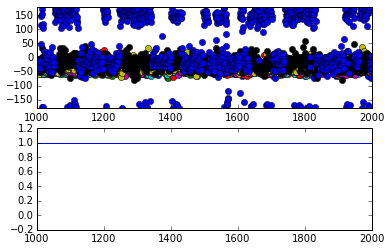

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(psi[1]*180/math.pi,'o')
ax2.plot(y)
ax1.set_xlim(1000,2000)
ax1.set_ylim(-180,180)
ax2.set_xlim(1000,2000)
ax2.set_ylim(-0.2,1.2)
